In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image processing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# MNIST dataset
mnist = datasets.MNIST(root='./data', 
                        train=True, 
                        transform=transform, 
                        download=True)

# Data loader
data_loader = DataLoader(dataset=mnist, 
                         batch_size=batch_size, 
                         shuffle=True)

# Discriminator
D = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
    nn.LeakyReLU(0.2),
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
    nn.LeakyReLU(0.2),
    nn.Flatten(),
    nn.Linear(128*7*7, 1),
    nn.Sigmoid()
).to(device)

# Generator
G = nn.Sequential(
    nn.Linear(latent_dim, 256*7*7),
    nn.ReLU(),
    nn.Unflatten(1, (256, 7, 7)),
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1),
    nn.Tanh()
).to(device)

# Binary cross entropy loss and optimizer

In [15]:
# Hyperparameters
latent_dim = 100
num_epochs = 1
batch_size = 64
lr = 0.0002
beta1 = 0.5

from tqdm.auto import tqdm

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

def train(D, G, criterion, d_optimizer, g_optimizer, data_loader):
    for epoch in tqdm(range(num_epochs)):
        for i, (images, _) in tqdm(enumerate(data_loader)):
            
            if i > 500: break
            
            batch_size = images.size(0)
            images = images.to(device)
            
            # Create labels
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            
            # Train Discriminator
            outputs = D(images)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs
            
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = G(z)
            outputs = D(fake_images)
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs
            
            d_loss = d_loss_real + d_loss_fake
            
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            # Train Generator
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = G(z)
            outputs = D(fake_images)
            
            g_loss = criterion(outputs, real_labels)
            
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            if (i+1) % 20 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}, D(x): {real_score.mean().item()}, D(G(z)): {fake_score.mean().item()}')

# Start training
train(D, G, criterion, d_optimizer, g_optimizer, data_loader)

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch [1/1], Step [20/938], d_loss: 0.5428409576416016, g_loss: 1.7149933576583862, D(x): 0.771415114402771, D(G(z)): 0.20620761811733246
Epoch [1/1], Step [40/938], d_loss: 0.13734766840934753, g_loss: 2.8712494373321533, D(x): 0.9510857462882996, D(G(z)): 0.0792873203754425
Epoch [1/1], Step [60/938], d_loss: 0.20583628118038177, g_loss: 3.1616148948669434, D(x): 0.8911604881286621, D(G(z)): 0.07707847654819489
Epoch [1/1], Step [80/938], d_loss: 0.06108241155743599, g_loss: 3.757868766784668, D(x): 0.9697198867797852, D(G(z)): 0.029077092185616493
Epoch [1/1], Step [100/938], d_loss: 0.023934384807944298, g_loss: 4.540515899658203, D(x): 0.9879629611968994, D(G(z)): 0.011680042371153831
Epoch [1/1], Step [120/938], d_loss: 0.011763082817196846, g_loss: 5.383744716644287, D(x): 0.9930119514465332, D(G(z)): 0.004676245618611574
Epoch [1/1], Step [140/938], d_loss: 0.0077045988291502, g_loss: 5.703273773193359, D(x): 0.9957612156867981, D(G(z)): 0.0034257066436111927
Epoch [1/1], Step 

In [22]:
z = torch.randn(1, latent_dim).to(device)
img_t = G(z)
img = img_t.detach().numpy().reshape(28, 28)

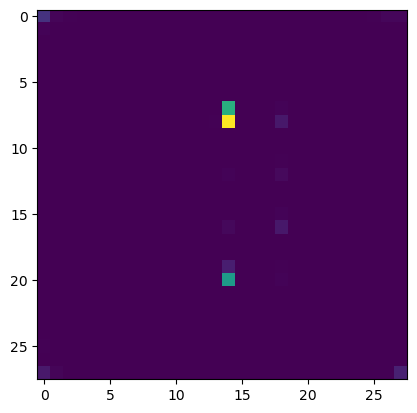

In [23]:
import matplotlib.pyplot as plt
plt.imshow(img)